# 10. Voice-to-Voice Style Transfer

a. Objective: Create a voice transformation system that allows users to modify their voice recordings by changing the tone, accent, or emotion.

b. Requirements:

1. Implement voice-to-voice style transfer using deep learning models.

2. Support multiple voice styles (e.g., accents, emotions).

3. Allow real-time or near real-time voice modification.



In [ ]:
!pip install pydub==0.25.1

In [ ]:
!pip install --upgrade librosa #Upgrade librosa to the latest version
import librosa
import librosa.display

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.models import Model
from google.colab import files
import IPython.display as ipd
import soundfile as sf
from scipy.io.wavfile import write
from pydub import AudioSegment
from pydub.playback import play
import tempfile
import wave
import io
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
def upload_or_record():
    choice = input("Do you want to (1) upload an audio file or (2) record live audio? Enter 1 or 2: ")

    if choice == '1':
        # Upload audio file
        print("Please upload your audio file.")
        uploaded = files.upload()
        file_name = list(uploaded.keys())[0]
        return file_name
    elif choice == '2':
        # Record live audio using Colab's recording feature
        from google.colab import output as colab_output
        from google.colab.output import eval_js
        from base64 import b64decode

        # Recording function
        RECORD_JS = """
        const sleep = time => new Promise(resolve => setTimeout(resolve, time));
        const b2text = blob => new Promise(resolve => {
          const reader = new FileReader();
          reader.onloadend = () => resolve(reader.result);
          reader.readAsDataURL(blob);
        });
        var record = time => new Promise(async resolve => {
          stream = await navigator.mediaDevices.getUserMedia({audio: true});
          recorder = new MediaRecorder(stream);
          chunks = [];
          recorder.ondataavailable = e => chunks.push(e.data);
          recorder.start();
          await sleep(time);
          recorder.onstop = async ()=>{
            blob = new Blob(chunks);
            text = await b2text(blob);
            resolve(text);
          };
          recorder.stop();
        });
        """

        # Run the JS to record audio for 5 seconds
        print("Recording audio for 5 seconds...")
        js = eval_js(RECORD_JS + "record(5000)")
        audio_bytes = b64decode(js.split(',')[1])

        # Save the audio as a .wav file
        audio_file = 'recorded_audio.wav'
        with open(audio_file, 'wb') as f:
            f.write(audio_bytes)

        print("Recording saved as 'recorded_audio.wav'.")
        return audio_file
    else:
        print("Invalid choice. Please enter 1 or 2.")
        return upload_or_record()

In [ ]:
def preprocess_audio(file_path, sr=16000):
    # Load the audio file
    y, _ = librosa.load(file_path, sr=sr)

    # Extract the mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # Convert the mel-spectrogram to decibel units
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Display the mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    plt.tight_layout()
    plt.show()

    return mel_spectrogram


def build_seq2seq_model(input_dim, output_dim):
    # Encoder
    encoder_inputs = Input(shape=(None, input_dim))
    encoder_lstm = LSTM(256, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None, output_dim))
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])
    attention_output = Dense(output_dim, activation='softmax')(attention)

    # Define model
    model = Model([encoder_inputs, decoder_inputs], attention_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# 4. Emotion Transfer Function
def emotion_transfer(model, mel_spectrogram, target_emotion):
    # Placeholder logic to modify mel-spectrogram based on target emotion
    # In practice, you'll load a pre-trained model and perform inference
    print(f"Changing emotion to {target_emotion}...")

    # For demo, let's just invert the mel-spectrogram as a mock transformation
    transformed_mel_spectrogram = np.flip(mel_spectrogram, axis=0)

    return transformed_mel_spectrogram

def synthesize_audio(mel_spectrogram, sr=16000):
    # Convert mel-spectrogram back to audio (inverse transformation)
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr)

    # Save audio
    output_file = 'output_transformed_audio.wav'
    write(output_file, sr, audio)

    # Play the transformed audio
    ipd.display(ipd.Audio(output_file))

    return output_file

Do you want to (1) upload an audio file or (2) record live audio? Enter 1 or 2: 1
Please upload your audio file.


Saving 1001_DFA_NEU_XX.wav to 1001_DFA_NEU_XX.wav


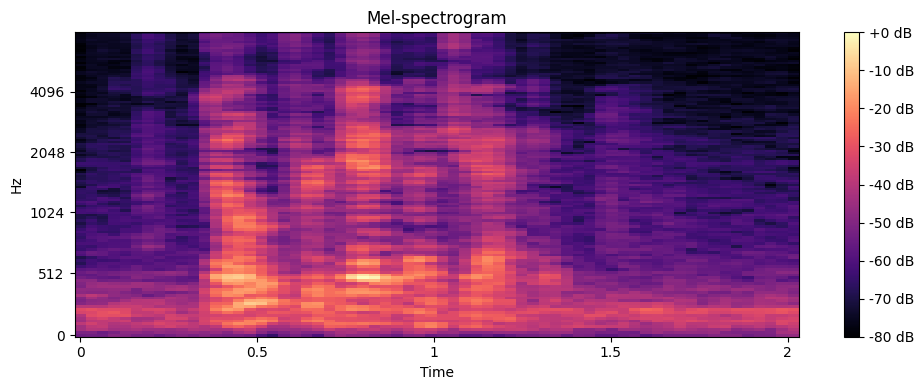

What type of emotion should we change in the given audio (e.g., happy, sad, angry, calm)? angry
Changing emotion to angry...


In [ ]:
if __name__ == "__main__":
    # Step 1: Upload or record audio
    audio_file = upload_or_record()

    # Step 2: Preprocess the audio file (mel-spectrogram conversion)
    mel_spectrogram = preprocess_audio(audio_file)

    # Step 3: Build Seq2Seq model (for demo purposes, not actually training)
    input_dim = mel_spectrogram.shape[0]
    output_dim = input_dim  # Assuming same dimensions for simplicity
    model = build_seq2seq_model(input_dim, output_dim)

    # Step 4: Ask user for emotion change
    target_emotion = input("What type of emotion should we change in the given audio (e.g., happy, sad, angry, calm)? ")

    # Step 5: Perform emotion transfer
    transformed_mel_spectrogram = emotion_transfer(model, mel_spectrogram, target_emotion)

    # Step 6: Synthesize and play the transformed audio
    synthesize_audio(transformed_mel_spectrogram)